In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model, Model
from loss import custom_loss_wrapper
import os
import h5py
import glob
from utils import convertXY2PtPhi

2025-07-10 17:17:24.133683: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
model_dir = (
    "/home/users/dprimosc/L1METML/experiments/l1metml_v1/25May21_normf100_clip_140X/"
)
model_name = "25May21_normf100_clip_140Xmodel.h5"
model = load_model(
    model_dir + model_name, custom_objects={"custom_loss": custom_loss_wrapper}
)

In [3]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_cat0 (InputLayer)     [(None, 128)]                0         []                            
                                                                                                  
 input_cat1 (InputLayer)     [(None, 128)]                0         []                            
                                                                                                  
 embedding0 (Embedding)      (None, 128, 2)               12        ['input_cat0[0][0]']          
                                                                                                  
 embedding1 (Embedding)      (None, 128, 2)               8         ['input_cat1[0][0]']          
                                                                                              

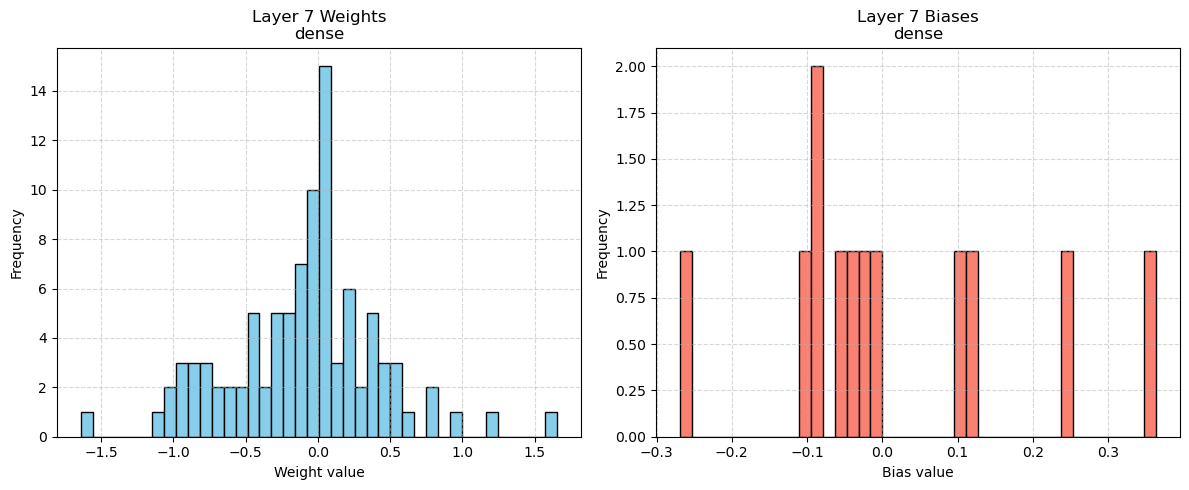

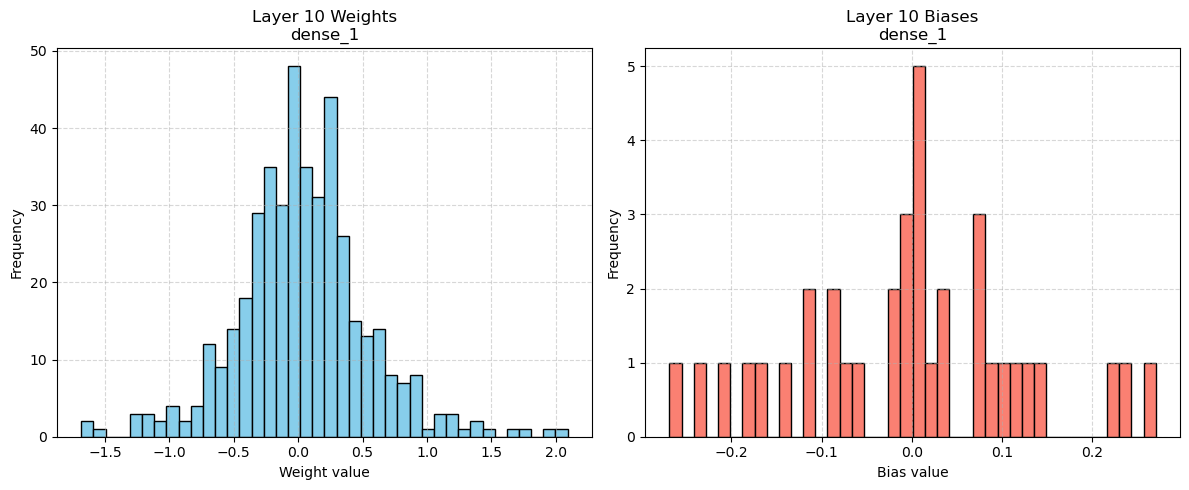

In [4]:
# Plot histograms of weights and biases for layers 7 and 10


def plot_weights_biases(model, layer_idx):
    layer = model.layers[layer_idx]
    weights = layer.get_weights()
    plt.figure(figsize=(12, 5))

    if len(weights) == 2:
        w, b = weights
        plt.subplot(1, 2, 1)
        plt.hist(w.flatten(), bins=40, color="skyblue", edgecolor="black")
        plt.title(f"Layer {layer_idx} Weights\n{layer.name}")
        plt.xlabel("Weight value")
        plt.ylabel("Frequency")
        plt.grid(True, linestyle="--", alpha=0.5)

        plt.subplot(1, 2, 2)
        plt.hist(b.flatten(), bins=40, color="salmon", edgecolor="black")
        plt.title(f"Layer {layer_idx} Biases\n{layer.name}")
        plt.xlabel("Bias value")
        plt.ylabel("Frequency")
        plt.grid(True, linestyle="--", alpha=0.5)

        plt.tight_layout()
        plt.show()
    else:
        print(f"Layer {layer_idx} does not have both weights and biases.")


plot_weights_biases(model, 7)
plot_weights_biases(model, 10)

In [11]:
layer = model.layers[14]
weights = layer.get_weights()

if len(weights) >= 1:
    w = weights[0]
    print(f"Weights of layer 14 ({layer.name}):\n", w)
else:
    print("Layer 14 does not have weights.")

Weights of layer 14 (met_weight_minus_one):
 [1.]


In [15]:
from tensorflow.keras.layers import Input, BatchNormalization
from tensorflow.keras.models import Model

# Create input layer for a single scalar value
input_layer = Input(shape=(1,), name="input_w")

# Add BatchNormalization layer with specified parameters
bn_layer = BatchNormalization(trainable=False, name="met_weight_minus_one", epsilon=0)(
    input_layer
)

# Create the model
simple_model = Model(inputs=input_layer, outputs=bn_layer)

simple_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_w (InputLayer)        [(None, 1)]               0         
                                                                 
 met_weight_minus_one (Batc  (None, 1)                 4         
 hNormalization)                                                 
                                                                 
Total params: 4 (16.00 Byte)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 4 (16.00 Byte)
_________________________________________________________________


In [20]:
# Set BatchNormalization weights to zero for gamma and beta, and ones for moving mean and variance
# BatchNormalization weights order: [gamma, beta, moving_mean, moving_variance]
# Create input of ones
input_ones = np.ones((1, 1), dtype=np.float32)
simple_model.get_layer("met_weight_minus_one").set_weights(
    [np.array([1.0]), np.array([-1.0]), np.array([0.0]), np.array([1.0])]
)

# Predict using the model
output = simple_model.predict(input_ones)
print("Input:\n", input_ones)
print("Output:\n", output)

1/1 [==============================] - 0s 41ms/step
Input:
 [[1.]]
Output:
 [[0.]]


32/32 [==============================] - 0s 468us/step


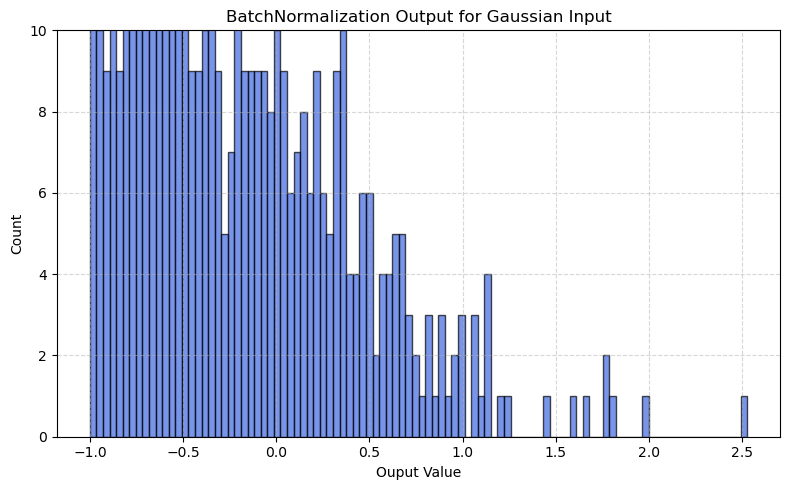

In [29]:
# Generate random Gaussian input with 100 entries
input_gaussian = np.random.normal(loc=0, scale=1, size=(1000, 1)).astype(np.float32)
input_gaussian_clipped = np.clip(input_gaussian, 0, None)
# Predict using the simple_model
output_gaussian = simple_model.predict(input_gaussian_clipped)
simple_model.get_layer("met_weight_minus_one").set_weights(
    [np.array([1.0]), np.array([-1.0]), np.array([0.0]), np.array([1.0])]
)

# Plot input vs output
plt.figure(figsize=(8, 5))
plt.hist(output_gaussian, color="royalblue", alpha=0.7, edgecolor="k", bins=100)
plt.title("BatchNormalization Output for Gaussian Input")
plt.xlabel("Ouput Value")
plt.ylabel("Count")
plt.ylim(0, 10)
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()